# Что тут происходит
> пытаемся запустить многоклассовую сегментацию
> есть выделение масок разных классов
> и дальнейшее объединение в один тензор
> куча всего теперь там индексный тензор, который тоже ему не подходит...
# Продолжаем мучить нашу сегментацию.
В этот раз сделаем собственную модель Unet для обучения.
- [ ] Не работает функция display_random_image в 5 пункте. 
- [x] Не нравится, что rgb_to_label делает разные цвета для одних и тех же классов на разных масках. Где-то виноградник чисто белый, где-то серый... Мне показалаось. Все правильно, я проверила в матрице. Это графики плохо отрисовывают...


# Импорт библиотек

In [2]:
!pip install albumentations --user

In [3]:
!pip install opencv

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import json
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import gc
import os
import re
import shutil

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
import torchmetrics

from torchinfo import summary
from torchview import draw_graph

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

from PIL import Image

# Установка параметров нашей модели

In [33]:
# Создадим пути к папке с изображениями
#TRAIN_DATA_PATH = 'D:/SNO/WINEYARD/DIFF_VAR/tynshun_wineyard_coco_panoptic/export_coco-panoptic_tynshun_wineyard_v.0.1.json'

ANNOTATION_DATA_PATH = 'C:/Users/Asus/Documents/tynshun_wineyard_coco_panoptic/export_coco-panoptic_tynshun_wineyard_v.0.1.json'
DATA_DIR = 'C:/Users/Asus/Documents/tynshun_wineyard_coco_panoptic/v.0.1/'

# Создадим пути к папкам train, val, test
TRAIN_DIR = 'C:/Users/Asus/Documents/tynshun_wineyard_coco_panoptic/coco_panoptic/train/'
VAL_DIR = 'C:/Users/Asus/Documents/tynshun_wineyard_coco_panoptic/coco_panoptic/val/'
TEST_DIR = 'C:/Users/Asus/Documents/tynshun_wineyard_coco_panoptic/coco_panoptic/test/'

# Выберем устройство для вычислений
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Выставим гиперпараметры
EPOCHS = 10        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 224     # Size of image 320
BATCH_SIZE = 32    # Batch size


# 1. Разобьем нашу папку на train, val, test. Нужно всего один раз!

## 1.1. Удалим все не нужные файлы

In [6]:
folder_path = DATA_DIR

# Получаем список файлов в папке
file_list = os.listdir(folder_path)
# Задаем шаблон для поиска файлов второго типа
pattern = re.compile(r'frame_\d+_label_ground-truth\.png')
# Проходим по каждому файлу и удаляем файлы второго типа
for file_name in file_list:
    if pattern.match(file_name):
        os.remove(os.path.join(folder_path, file_name))
        print(f'Файл {file_name} удален.')

print("Удаление завершено.")


Удаление завершено.


## 1.2. Создадим два списка файлов - маски и изображения

In [7]:
file_list = os.listdir(DATA_DIR)
image_list = []
mask_list = []
pattern_image = re.compile(r'frame_\d+\.jpg')
pattern_mask = re.compile(r'frame_\d+_label_ground-truth_coco-panoptic\.png')
for file_name in file_list:
    if pattern_image.match(file_name):
        image_list.append(file_name)
    if pattern_mask.match(file_name):
        mask_list.append(file_name)
    
image_list, mask_list

(['frame_10853.jpg',
  'frame_10854.jpg',
  'frame_10889.jpg',
  'frame_10926.jpg',
  'frame_10928.jpg',
  'frame_10989.jpg',
  'frame_11013.jpg',
  'frame_11026.jpg',
  'frame_11566.jpg',
  'frame_11569.jpg',
  'frame_11578.jpg',
  'frame_11594.jpg',
  'frame_11611.jpg',
  'frame_11647.jpg',
  'frame_11651.jpg',
  'frame_11652.jpg',
  'frame_11665.jpg',
  'frame_11702.jpg',
  'frame_11738.jpg',
  'frame_11749.jpg',
  'frame_11754.jpg',
  'frame_11788.jpg',
  'frame_11819.jpg',
  'frame_11893.jpg',
  'frame_11912.jpg',
  'frame_11920.jpg',
  'frame_11927.jpg',
  'frame_11928.jpg',
  'frame_12019.jpg',
  'frame_12021.jpg',
  'frame_12042.jpg',
  'frame_12046.jpg',
  'frame_12064.jpg',
  'frame_12067.jpg',
  'frame_12075.jpg',
  'frame_12077.jpg',
  'frame_12124.jpg',
  'frame_12137.jpg',
  'frame_12154.jpg',
  'frame_12195.jpg',
  'frame_12207.jpg',
  'frame_12222.jpg',
  'frame_12229.jpg',
  'frame_12250.jpg',
  'frame_12259.jpg',
  'frame_12272.jpg',
  'frame_12281.jpg',
  'frame_1229

## 1.3. Разделяем файлы на train, val и test

In [8]:
train_list, test_val_list = train_test_split(image_list, test_size=0.3, random_state=42)
val_list, test_list = train_test_split(test_val_list, test_size=0.33, random_state=42)
len(train_list), len(val_list), len(test_list)

(210, 60, 30)

In [9]:
# Проходимся по каждому файлу изображения
for image_file in train_list:
    # Проверяем, существует ли соответствующая маска
    image_name, image_extension = os.path.splitext(image_file)
    mask_file = f"{image_name}_label_ground-truth_coco-panoptic.png"
    mask_path = os.path.join(DATA_DIR, mask_file)
    
    # Если маска существует, копируем изображение и маску в папку назначения
    if os.path.exists(mask_path):
        # Копируем изображение
        shutil.copy(os.path.join(DATA_DIR, image_file), os.path.join(TRAIN_DIR, image_file))
        # Копируем маску
        shutil.copy(mask_path, os.path.join(TRAIN_DIR, mask_file))


In [10]:
# Проходимся по каждому файлу изображения
for image_file in val_list:
    # Проверяем, существует ли соответствующая маска
    image_name, image_extension = os.path.splitext(image_file)
    mask_file = f"{image_name}_label_ground-truth_coco-panoptic.png"
    mask_path = os.path.join(DATA_DIR, mask_file)
    
    # Если маска существует, копируем изображение и маску в папку назначения
    if os.path.exists(mask_path):
        # Копируем изображение
        shutil.copy(os.path.join(DATA_DIR, image_file), os.path.join(VAL_DIR, image_file))
        # Копируем маску
        shutil.copy(mask_path, os.path.join(VAL_DIR, mask_file))


In [11]:
# Проходимся по каждому файлу изображения
for image_file in test_list:
    # Проверяем, существует ли соответствующая маска
    image_name, image_extension = os.path.splitext(image_file)
    mask_file = f"{image_name}_label_ground-truth_coco-panoptic.png"
    mask_path = os.path.join(DATA_DIR, mask_file)
    
    # Если маска существует, копируем изображение и маску в папку назначения
    if os.path.exists(mask_path):
        # Копируем изображение
        shutil.copy(os.path.join(DATA_DIR, image_file), os.path.join(TEST_DIR, image_file))
        # Копируем маску
        shutil.copy(mask_path, os.path.join(TEST_DIR, mask_file))

# 2. Вспомогательные функции

## 2.1. Загрузка JSON-файла аннотаций COCO

In [5]:
def get_df_images_masks(path_to_coco, path_to_dir):
    with open(path_to_coco, 'r') as f:
        coco_data = json.load(f)
        df_images = pd.DataFrame(coco_data['images'])
        df_images['file_name'] = df_images['file_name'].apply(lambda x: path_to_dir + x)
        df_images.rename(columns={'id': 'image_id'}, inplace=True)
        df_annotations = pd.DataFrame(coco_data['annotations'])
        df_annotations['file_name'] = df_annotations['file_name'].apply(lambda x: path_to_dir + x)
        # Склеивание DataFrame по столбцу 'id'
        merged_df = pd.merge(df_images, df_annotations, on='image_id')
        merged_df.rename(columns={'file_name_x': 'images'}, inplace=True)
        merged_df.rename(columns={'file_name_y': 'masks'}, inplace=True)
        return merged_df

## 2.2. Функция по поиску классов сегментации и словаря цветов сегментации
## **Гипотетически надо будет поменять на tuple**

In [7]:
def find_classes(directory: str): # указать возвращаемый тип данных
    # дописать многострочный комментарий
    '''
    Функция используется в самодельном классе Dataset
    '''
    with open(directory, 'r') as f:
        data_json = json.load(f)

    type(data_json['categories'])


    classes = ['__background__']
    colors = [[0, 0, 0]]

    colors_idx = dict()
    colors_idx['__background__'] = [0, 0, 0]

    classes_idx = dict()
    classes_idx['__background__'] = 0

    for el in data_json['categories']:
        classes.append(el['name'])
        colors.append(el['color'])
    classes_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    for i in range(len(classes)):
        colors_idx[classes[i]] = colors[i]

    return classes, classes_idx, colors_idx

## 2.3. Функция для вывода 5 случайных изображений

In [6]:
def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.COLOR_BGR2RGB) / 255.0 #перевод в серую шкалу и нормализация! ВАУ!

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

## 2.4. Функция для отображения

In [8]:
def show_image_from_df(image_path):
    image = cv2.imread(image_path)
  # Отображение изображения
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 2.5 Получим список файлов в папке

In [9]:
def get_files_list(folder_path):
    return os.listdir(folder_path)

## 2.6 Получим список изображений и масок в папке

In [10]:
def get_image_and_mask_lists(file_list):
    # Получение пути изображения и маски
    image_list = []
    mask_list = []
    pattern_image = re.compile(r'frame_\d+\.jpg')
    pattern_mask = re.compile(r'frame_\d+_label_ground-truth_coco-panoptic\.png')
    for file_name in file_list:
        if pattern_image.match(file_name):
            image_list.append(file_name)
        if pattern_mask.match(file_name):
            mask_list.append(file_name) 
            
    return image_list, mask_list

In [11]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    if seed:
        random.seed(seed)

    random_array = np.random.randint(0, len(dataset), n)
    print(random_array)
    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(random_array):
        image, mask = dataset[idx]
        plt.subplot(2, 5, i+1)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.axis('off')
        plt.title("IMAGE")

        plt.subplot(2, 5, i+6)
        plt.imshow(np.transpose(mask, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title("GROUND TRUTH")
    plt.tight_layout()
    plt.show()


# 3. Исследуем наши данные

In [12]:
df = get_df_images_masks(ANNOTATION_DATA_PATH, DATA_DIR)
df.head()
print(df.shape)

(300, 6)


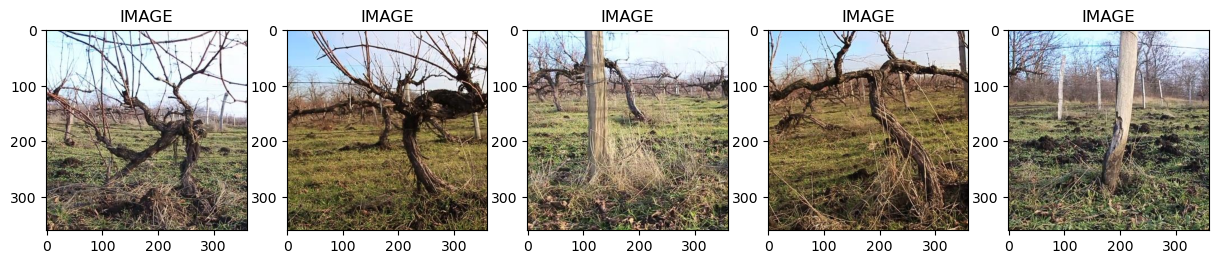

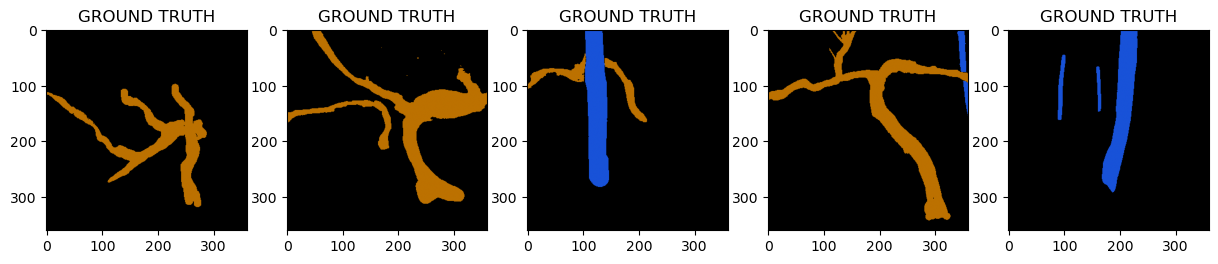

In [13]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]# выберем 5 случайных индексов из нашего df
generate_sample_images(sample)
generate_sample_masks(sample)

# 4. Data Augmentation

In [76]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [22]:
# Creating a data augmentation compose for transforming the data
aug_transform = A.Compose([
    A.RandomSizedCrop(min_max_height=(3500, 4000), height=4000, width=6000, w2h_ratio=1.5, p=0.8),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(45, 225), interpolation=cv2.INTER_NEAREST, p=0.8),
    A.OneOf([
        A.GridDistortion(interpolation=cv2.INTER_NEAREST, p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5)
    ], p=0.8),
    A.CLAHE(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1.0)
], p=1.0)

NameError: name 'A' is not defined

# 5. Работа с Dataset

## 5.1. Полезные размышления. В новую версию блокнота можно не включать

здесь я хочу переписать его следующим образом... вместо targ_dir сделать df и с ним работать также как и в v0.0.1

In [68]:
def rgbmask_to_label(rgb_mask: np.ndarray,
                     colormap: list):
        """
        Converts a single RGB mask into one-hot encoding mask and finally
        creates a single channel class index label.
        Parameters:
            rgb_mask: An array containing the mask in RGB format and shape (HWC).
            colormap: A list with all the RGB colors for every single class
                      in the proper sequence.
        Returns:
            output: An array that is converted from RGB mask to label encoded in
                    shape (H x W).
        """
        # An array to fill the output later.
        output = np.zeros(rgb_mask.shape[:2])

        for label, color in enumerate(colormap):
            if label < len(colormap):
                # Matching the mask with the colormap
                # Then replace with classes index
                output[np.all(np.equal(rgb_mask, color), axis=-1)] = label

        return output

In [ ]:
class ImageFolderCustom(Dataset):
    def __init__(self, df, targ_dir, transform=None) -> None:
        # Упростили по сравнению с прошлой версией кода
        self.df = df
        self.transform = transform
        # Попробуем создать вывод классов
        self.classes, self.class_to_idx, self.colors_to_idx = find_classes(targ_dir)
        
    def __len__(self) -> int:
        return len(self.df)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int): # -> Tuple[torch.Tensor, int]:

        sample = self.df.iloc[index]
        image = sample.images # путь к файлу изобржания
        mask = sample.masks # путь к файлу маски

        # Чтение images and masks. МБ ФУНКЦИЕЙ  def load_image(self, index: int) -> Image.Image:
        image = Image.open(image)
        mask = Image.open(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask # return data, label (X, y)

In [ ]:
train_data_custom = ImageFolderCustom(df=train_df, targ_dir=TRAIN_DATA_PATH, transform=train_transforms)
test_data_custom = ImageFolderCustom(df=test_df, targ_dir=TRAIN_DATA_PATH, transform=test_transforms)
print('train_data_custom.class_to_idx', train_data_custom.class_to_idx)
print('len(train_data_custom), len(test_data_custom)', len(train_data_custom), len(test_data_custom))
train_data_custom.colors_to_idx

In [ ]:
image_path = train_df.iloc[231]['masks']
image = Image.open(image_path)

# Преобразовать изображение в массив NumPy
image_np = np.array(image)
# Добавить дополнительное измерение для совместимости с формой, ожидаемой моделью
image_np = np.expand_dims(image_np, axis=0)

# Преобразовать в формат torch.Tensor и нормализовать
image = torch.Tensor(image_np)# / 255.0

print(image)
# Убедитесь, что image имеет правильную форму и тип данных
print(image.shape)  # Печатает (1, height, width)
print(image.dtype)  # Печатает torch.float32

plt.imshow(image_np[0], cmap='gray')  # Передаем нулевой индекс, так как у нас есть дополнительное измерение
plt.axis('off')  # Отключаем оси координат
plt.show()

In [89]:
colormap = {'__background__': [0, 0, 0], 'wine': [0, 113, 188], 'post': [216, 82, 24]}.values()
print(colormap)
# mask_path = train_df.iloc[231]['masks']
mask = Image.open('D:/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_8071_label_ground-truth_coco-panoptic.png')
mask = np.array(mask)
print(type(mask[0][0][0]))
output = np.zeros(mask.shape[:2])
for label, color in enumerate(colormap):
    print(label, color)
    if label < len(colormap):
        output[np.all(np.equal(mask, color), axis=-1)] = label
        
print(output)

dict_values([[0, 0, 0], [0, 113, 188], [216, 82, 24]])


FileNotFoundError: [Errno 2] No such file or directory: 'D:/SNO/WINEYARD/DIFF_VAR/COCO_PANOPTIC/TEST/frame_8071_label_ground-truth_coco-panoptic.png'

In [ ]:
mask = torch.from_numpy(mask).type(torch.LongTensor)

In [ ]:
train_data_custom[48][1].shape

## Find

In [106]:
image_list, mask_list = get_image_and_mask_lists(os.listdir(DATA_DIR))
image_path = os.path.join(DATA_DIR, image_list[0])
mask_path = os.path.join(DATA_DIR, mask_list[0])

# Чтение файлов изображения и маски в формате RGB
# image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
# mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

image = Image.open(image_path)
mask = Image.open(mask_path)

# Преобразование изображения и масок с использованием аугментации
image = train_transforms(image)
mask = train_transforms(mask)
# Преобразование маски в формат кодированных меток
mask = (mask.detach().numpy() if type(mask) == torch.Tensor else mask)
mask = np.transpose(mask, (1, 2, 0))

image = image.permute(1, 2, 0)

# rgb_mask
output = np.zeros(mask.shape[:2])
for label, color in enumerate(colormap):
    if label < len(colormap):
        output[np.all(np.equal(mask, color), axis=-1)] = label
        
#mask = rgbmask_to_label(rgb_mask=mask, colormap=[[0, 0, 0], [0, 113, 188], [216, 82, 24]])
mask = torch.from_numpy(mask).type(torch.LongTensor)
mask, image.shape

(tensor([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         ...,
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]),
 torch.Size([224, 224, 3]))

## 5.2. class MultiClassDataset(Dataset):

Создадим свой класс для датасета. На этот раз для многоклассовой сегментации

In [107]:
# Creating the dataset class
class MultiClassDataset(Dataset):
    """
        dataset_dir: str - TRAIN_DATA, VAL_DATA, TEST_DATA 
    """
    def __init__(self,
                 dataset_dir: str, # TRAIN_DIR VAL_DIR TEST_DIR
                 annotation_dir: str,
                 #file_list: list,
                 #image_list=None,
                 #mask_list:=None,
                 transform=None):
        self.dataset_dir = dataset_dir  
        self.file_list = os.listdir(dataset_dir)
        self.image_list, self.mask_list = get_image_and_mask_lists(os.listdir(dataset_dir))
        #self.image_list = image_list
        #self.mask_list = mask_list        
        self.classes, self.class_to_idx, self.colors_to_idx = find_classes(annotation_dir)
        self.colormap = self.colors_to_idx.values()
        self.transform = transform

    def rgbmask_to_label(self,
                         rgb_mask: np.ndarray,
                         colormap: list):
        """
        Converts a single RGB masks into onehot encoding masks and finally
        creates a single channel class index label.
        Parameters:
            rgb_mask: A array containing the mask in RGB format and shape (HWC).
            colormap: A list with all the RGB colors for every single class
                      in proper sequence.
        Returns:
            output: A array that is converted from RGB mask to label encoded in
                    shape (H x W).
        """
        # A array to fill the output later.
        output = np.zeros(rgb_mask.shape[:2])

        for label, color in enumerate(colormap):
            if label < len(colormap):
                # Matching the mask with the colormap
                # Then replacing with classes index
                output[np.all(np.equal(rgb_mask, color), axis=-1)] = label

        return output


    
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        
        image_path = os.path.join(self.dataset_dir, self.image_list[index])
        mask_path = os.path.join(self.dataset_dir, self.mask_list[index])

        # Чтение файлов изображения и маски в формате RGB
        #image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        #mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        # Преобразование изображения и масок с использованием аугментации
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
            
            #aug = self.transform(image=image, mask=mask)
            #image = aug['image']
            #mask = aug['mask']
        
        #mask = np.array(mask)
        mask = (mask.detach().numpy() if type(mask) == torch.Tensor else mask)
        mask = np.transpose(mask, (1, 2, 0))
        image = image.permute(1, 2, 0)
        mask = self.rgbmask_to_label(rgb_mask=mask, colormap=self.colormap)
        mask = torch.from_numpy(mask).type(torch.LongTensor)

        
        # Преобразование маски в формат кодированных меток
        #mask = (mask.detach().numpy() if type(mask) == torch.Tensor else mask)
        #mask = self.rgbmask_to_label(rgb_mask=mask, colormap=self.colormap)
        #mask = torch.from_numpy(mask).type(torch.LongTensor)
        
        return image, mask

In [108]:
dataset = MultiClassDataset(TRAIN_DIR, ANNOTATION_DATA_PATH, transform = train_transforms)

In [109]:
train_dataset = MultiClassDataset(TRAIN_DIR, ANNOTATION_DATA_PATH, transform = train_transforms)
val_dataset = MultiClassDataset(VAL_DIR, ANNOTATION_DATA_PATH, transform = train_transforms)
test_dataset = MultiClassDataset(TEST_DIR, ANNOTATION_DATA_PATH, transform = train_transforms)

## 5.3. Display sample random images

Size of the dataset: 210
Shape of Image: torch.Size([224, 224, 3]) and mask: torch.Size([224, 224])
Classes in the mask images: [0]

Plotting the data:


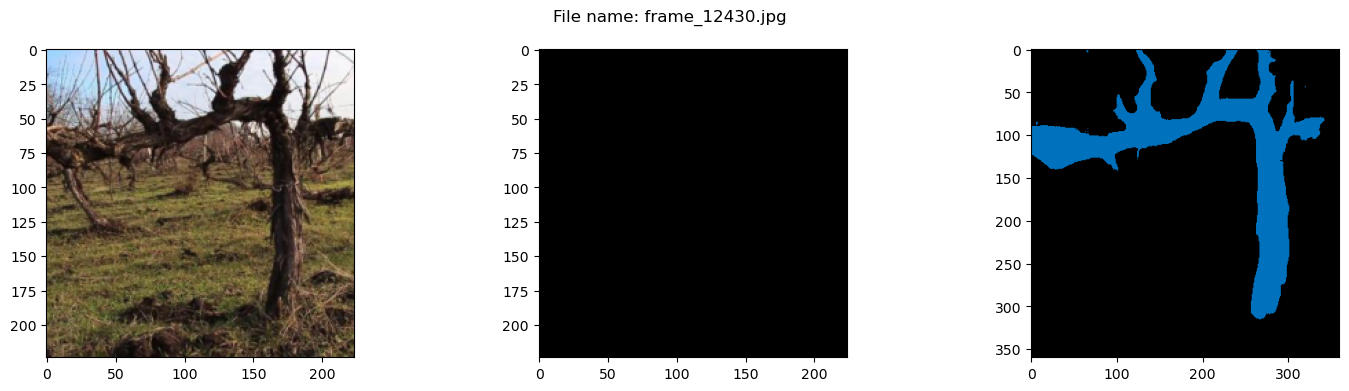

In [111]:
rand_num = np.random.randint(len(dataset))
image, mask = dataset[rand_num]

print(f'Size of the dataset: {len(dataset)}')
print(f'Shape of Image: {image.shape} and mask: {mask.shape}')
print(f'Classes in the mask images: {np.unique(mask)}')
print('\nPlotting the data:')

filename = dataset.image_list[rand_num]
maskname = dataset.mask_list[rand_num]
plt.figure(figsize=(18, 4))
plt.suptitle(f'File name: {filename}')
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(mask, 'gray')
plt.subplot(133)
plt.imshow(plt.imread(os.path.join(dataset.dataset_dir, maskname)))

### Не работает...

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(dataset,
                      n=5,
                      classes=dataset.classes,
                      seed=None)

# 6. Создадим DataLoader

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

print(f"Общее количество батчей в Train Loader: {len(train_dataloader)}")
print(f"Общее количество батчей в in Val Loader: {len(val_dataloader)}")
print(f"Общее количество батчей в in Test Loader: {len(test_dataloader)}")

Общее количество батчей в Train Loader: 7
Общее количество батчей в in Val Loader: 2
Общее количество батчей в in Test Loader: 1


In [20]:
for image, mask in train_dataloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([32, 360, 360, 3])
Size of one batch of masks: torch.Size([32, 360, 360])


# 7. Создадим нашу Unet модель

Модель имеет такое же представление, как указано в названии. Модель U-образной формы. Причина U-образной формы кроется в работе модели, модель начинается с левой стороны и движется к центру, сжимая данные и сохраняя только особенности изображения, эта часть модели даже называется кодировщиком. Затем данные перемещаются в правый угол, где данные реконструируются со всеми известными признаками и представляются в виде маски, эта часть модели называется декодером.

![UNet++ architecture](https://pic.imgdb.cn/item/60dac54e5132923bf81d4a25.jpg)

I will now create the Segmentation model using the Unet++ architecture. The parameters used for the model are:
- **Efficient Net** is used as the encoder model
- Weights used are of **Imagenet**
- Input channels are 3 due to **RGB** images

In the forward method I defined the loss functions. DiceLoss and Binary Cross Entropy are used as loss functions for this task.

[Dice loss](https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.) is a metric commonly used to evaluate the performance of machine learning models in image segmentation tasks. It is a measure of the dissimilarity between the predicted segmentation (mask) and the true segmentation of an image.

### DoubleConvLayer

In [26]:
class DoubleConvLayer(nn.Module):
    """
    Creates two convolution layers with batch normalization
    and relu activation.
    These convolution layers do not change the spatial dimension
    and only affects the feature dimension.
    If you check the architecture dig., this class creates the
    layer indicated by the blue arrow.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            # First convolution layer
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),

            # Second convolution layer
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

## 7.1. Напишем Encoder
Путь кодировщика принимает данные изображения и постепенно начинает выполнять метод понижающей дискретизации, это выполняется с помощью свертки и объединения слоев.

Если вы посмотрите на архитектуру, то можете заметить закономерность: все слои понижающей выборки имеют два слоя свертки. мы создадим класс torch.nn.Module, имеющий два слоя свертки. При использовании слоев свертки мы не будем изменять пространственное измерение, применяя отступы и вместе со сверткой пакетную нормализацию для смещения и активацию ReLU, чтобы сделать его нелинейным.

### DownSampling

In [27]:
class DownSampling(nn.Module):
    """
    This class implements the downsampling part of the architecture.
    If you check the architecture dig., the left path displays the red arrow
    indicating the downsampled layer using the max pool.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_sample = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Initializing the layer using the double convolution layer class
            DoubleConvLayer(in_channels=in_channels,
                            out_channels=out_channels)
        )

    def forward(self, x):
        return self.down_sample(x)

> При использовании понижающей дискретизации модель изучает особенности изображения, но также теряет пространственную информацию. Итак, чтобы вернуть потерянные данные, нам нужно выполнить декодирование после этого.

## 7.2. Decoder(Expansion Path)

### UpSampling

In [28]:
class UpSampling(nn.Module):
    """
    This class implements the upsampling part of the architecture.
    If you check the architecture dig., the right path displays the green arrow
    indicating the upsampled layer.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Using Transposed convolution for upsampling
        self.up_sample = nn.ConvTranspose2d(in_channels=in_channels,
                                            out_channels=out_channels,
                                            kernel_size=2,
                                            stride=2)
        self.double_conv = DoubleConvLayer(in_channels=in_channels,
                                           out_channels=out_channels)

    def forward(self, x1, x2):
        """
        x1 is the output tensor of the previous layer, which will be upsampled.
        x2 is the skip connection tensor that was generated during
        downsampling.
        """
        x1 = self.up_sample(x1)

        # Correcting the shape after upsampling
        if x1.shape != x2.shape:
            x1 = TF.resize(img=x1, size=x2.shape[2:], antialias=True)

        x = torch.cat((x2, x1), 1)
        return self.double_conv(x)

## 7.3. Complete U-Net Architecture

Теперь, когда мы создали как понижающую, так и повышающую дискретизацию модели, мы можем завершить модель, собрав кусочки и завершив головоломку.

Мы начинаем с понижающей дискретизации для 4 слоев (включая входной слой), каждый слой увеличивает объекты в 2 раза и уменьшает пространственный размер в 2 раза.
Затем мы создаем нижний слой свертки, который предназначен только для передачи данных на этап повышения дискретизации.
Как только мы получаем данные нижнего уровня, он переходит к повышению дискретизации, а также принимает данные о пропущенном соединении из понижающей дискретизации и перемещается до 4 уровней.
Наконец, достигая последних слоев, данные проходят через последний слой, где данные объектов свернуты в соответствии с общим количеством присутствующих классов и формируют изображение в соответствии с исходной формой.

In [29]:
class UnetModel(nn.Module):
    def __init__(self,
                 n_classes: int,
                 in_channels=3):
        super().__init__()
        features = [64, 128, 256]
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.skip_connection = []

        # The input layer of the model [BCHW]
        # Eg. input tensor shape: [1, 3, 572, 572]
        self.encoder.append(DoubleConvLayer(in_channels=in_channels,
                                            out_channels=features[0]))
        # Eg. output tensor shape: [1, 64, 572, 572]

        # A 3 layer downsampling
        # Eg. input tensor shape: [1, 64, 572, 572]
        for feature in features:
            self.encoder.append(DownSampling(in_channels=feature,
                                             out_channels=feature * 2))
        # Eg. output tensor shape: [1, 512, 71, 71]

        # Bottom layer of the UNet Model
        # Eg. input tensor shape: [1, 512, 71, 71]
        self.bottom_layer = DownSampling(in_channels=features[-1]*2,
                                         out_channels=features[-1]*4)
        # Eg. output tensor shape: [1, 1024, 35, 35]

        # A 3-layer upsampling
        # Eg. input tensor shape: [1, 1024, 35, 35]
        for feature in reversed(features):
            self.decoder.append(UpSampling(in_channels=feature * 4,
                                           out_channels=feature * 2))
        # Eg. output tensor shape: [1, 128, 286, 286]

        # Upsampling before the final layer
        # Eg. input tensor shape: [1, 128, 286, 286]
        self.decoder.append(UpSampling(in_channels=features[1],
                                       out_channels=features[0]))
        # Eg. output tensor shape: [1, 64, 572, 572]

        # Final layer of the model, giving the predicted mask
        # Eg. input tensor shape: [1, 64, 572, 572]
        self.final_layer = nn.Conv2d(in_channels=features[0],
                                     out_channels=n_classes,
                                     kernel_size=1)
        # Eg. output tensor shape: [1, n_classes, 572, 572]

    def forward(self, x):
        for encode in self.encoder:
            x = encode(x)
            # Appending all the downsampled output for skip connection
            self.skip_connection.append(x)

        x = self.bottom_layer(x)

        for decode, skip in zip(self.decoder,
                                reversed(self.skip_connection)):
            # Upsampling using the skip connection that was collected durning downsampling
            x = decode(x, skip)

        return self.final_layer(x)

## 7.4. Проверка работы модели

In [30]:
# Performing a unit test to check whether the model works or not
x = torch.randn((3, 3, 224, 224))
model = UnetModel(n_classes=3, in_channels=3)
output = model(x)
assert x.shape[2:] == output.shape[2:]
print(f'Input shape: {x.shape} and output shape: {output.shape}')

Input shape: torch.Size([3, 3, 224, 224]) and output shape: torch.Size([3, 3, 224, 224])


### Summary of the model

In [35]:
summary(model=UnetModel(n_classes=5),
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
UnetModel (UnetModel)                              [1, 3, 224, 224]     [1, 5, 224, 224]     --                   True
├─ModuleList (encoder)                             --                   --                   --                   True
│    └─DoubleConvLayer (0)                         [1, 3, 224, 224]     [1, 64, 224, 224]    --                   True
│    │    └─Sequential (double_conv)               [1, 3, 224, 224]     [1, 64, 224, 224]    38,848               True
│    └─DownSampling (1)                            [1, 64, 224, 224]    [1, 128, 112, 112]   --                   True
│    │    └─Sequential (down_sample)               [1, 64, 224, 224]    [1, 128, 112, 112]   221,696              True
│    └─DownSampling (2)                            [1, 128, 112, 112]   [1, 256, 56, 56]     --                   True
│    │    └─Sequential (down_sample)       

In [40]:
# Visualizing the model
# model_graph = draw_graph(UnetModel(5), input_size=(1,3,224,224), expand_nested=True)
# model_graph.visual_graph

#### SegmentationModel

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=3,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='multiclass')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

# 8. Метрики 

## Creating a function to calculate accuracy and DICE metrics while training the model

### calculate_accuracy

In [ ]:
# Creating a function to calculate accuracy and DICE metrics while training the model
def calculate_accuracy(pred: torch.Tensor,
                       target: torch.Tensor):
    """
    Calculate multi-class accuracy for the provided tensor while training the
    model
    Parameters:
        pred (torch.Tensor): Raw logits produced by the model, the shape of
                             the tensor needs to be (B,C,H,W).
        target (torch.Tensor): A ground truth tensor, that is label encoded of
                               shape (B,H,W).
    Returns: Accuracy score
    """
    assert len(pred.shape) == 4 and len(target.shape) == 3
    pred = nn.Softmax2d()(pred).argmax(1).int()
    target = target.int()
    return ((pred == target).sum() / torch.numel(target)).item()

### calculate_iou_dice

In [ ]:
def calculate_iou_dice(pred: torch.Tensor,
                       target: torch.Tensor,
                       n_classes: int):
    """
    Calculate multi-class DICE and IoU score for the provided tensor while
    training the model
    Parameters:
        pred (torch.Tensor): Raw logits produced by the model, the shape of
                             the tensor needs to be (B,C,H,W).
        target (torch.Tensor): A ground truth tensor, that is label encoded of
                               shape (B,H,W).
        n_classes (int): Total number of classes
    Returns:
        iou_array (numpy.ndarray): A array with iou score for all the classes.
        iou_mean (float): A average iou score.
        dice_array (numpy.ndarray): A array with dice score for all the classes.
        dice_mean (float): A average dice score.
    """
    assert len(pred.shape) == 4 and len(target.shape) == 3
    assert pred.shape[1] == n_classes
    dice_array = []
    iou_array = []

    # Getting the predicted labels for every pixel
    # Flattening both the predicted and groundtruth tensor
    pred = nn.Softmax2d()(pred).argmax(dim=1).view(-1)
    target = target.view(-1)

    # Looping through the data for each class and
    # calculating the DICE and Iou score
    for class_idx in range(n_classes):

        # Creating a tensor for matching classes
        pred_inds = pred == class_idx
        target_inds = target == class_idx

        # Calculating the IoU score
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() \
                + target_inds.long().sum().item() - intersection

        # Stopping the zero error for division
        if union == 0:
            iou = 0
            iou_array.append(iou)
            dice_array.append(iou)
        else:
            iou = intersection / union
            iou_array.append(iou)

            # Calculating the dice score
            dice = (2 * iou) / (iou + 1)
            dice_array.append(dice)

    # Getting the average of both the scores
    iou_mean = np.mean(iou_array)
    dice_mean = np.mean(dice_array)

    return (np.array(iou_array), iou_mean,
            np.array(dice_array), dice_mean)

## Function for saving and loading model checkpoint

### save_model_checkpoint

In [ ]:
# Function for saving and loading model checkpoint
def save_model_checkpoint(model,
                          optimizer,
                          dir_path='model',
                          filename: str = 'model_checkpoint.pth'):
    """
    A function to save the model and optimizers state.
    Parameters:
        model: A pytorch model that needs to be saved.
        optimizer: A pytorch optimizer that needs to be saved.
        dir_path: A string for the directory path to save the model.
        filename: A string for the filename, extension needs to be ".pt" or ".pth".
    """
    assert filename.split('.')[-1] in ['pt', 'pth'], \
           '[ERROR] filename extension must be either "pt" or "pth".'

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    obj_dict = {'model_state_dict': model.state_dict(),
                'optim_state_dict': optimizer.state_dict()}
    torch.save(obj_dict, os.path.join(dir_path, filename))

    print(f'[INFO] Checkpoint has been saved to the location:' \
          f'"{os.path.join(dir_path, filename)}".')


### load_model_checkpoint

In [ ]:
def load_model_checkpoint(model,
                          checkpoint_filepath: str = 'model_checkpoint.pth',
                          device=None):
    """
    A function to load the model state into an existing model of same architecture.
    Parameters:
        model: The model in which the state needs to be loaded.
        checkpoint_filepath: A string containing the file path, file extension
                             needs to be ".pth" or ".pt".
        device: A pytorch device to map the location of the loaded model.
    """
    assert checkpoint_filepath.split('.')[-1] in ['pt', 'pth'], \
        '[ERROR] filename extension must be either "pt" or "pth".'

    if not os.path.isfile(checkpoint_filepath):
        raise Exception(f'[ERROR] File "{checkpoint_filepath}" does not exists.')

    print(f'[INFO] Loading model from checkpoint location: "{checkpoint_filepath}".')

    obj_dict = torch.load(checkpoint_filepath,
                          map_location=device)

    model.load_state_dict(obj_dict['model_state_dict'])

# Create Train and Validation Function
# Writing the training and testing step function

### train_step

In [21]:
# Writing the training step function
def train_step(model, dataloader, loss_fn, optimizer, num_classes, device):
    
    model.train()
    
    train_loss = 0
    #train_iou = torchmetrics.IoU(num_classes=num_classes)
    #train_dice = torchmetrics.Dice(num_classes=num_classes)
    train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
    
    for batch, (images, masks) in enumerate(dataloader):
        images, masks = images.to(device), masks.long().to(device)
        
        # forward pass...
        pred_masks = model(images)
        
        # calculate loss
        loss = loss_fn(pred_masks, masks)
        train_loss += loss.item()
        
        # optimizer zero grad
        optimizer.zero_grad()
        
        # loss backward
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        # Update IoU metric
        pred_labels = torch.argmax(pred_masks, dim=1)
        #train_iou.update(pred_labels, masks)
        #train_dice.update(pred_labels, masks)
        train_accuracy.update(pred_labels, masks)
    
    #  
    train_loss = train_loss / len(dataloader)
    train_acc /= len(dataloader)
    #train_iou_mean /= len(dataloader)
    #train_dice_mean /= len(dataloader)
    
    return (train_loss, train_acc) #, train_iou_mean, train_dice_mean)

### test_step

In [22]:
# Writing the testing step function
def test_step(model, dataloader, loss_fn, num_classes, device):
    
    model.eval()
    
    test_loss = 0
    #test_iou = torchmetrics.IoU(num_classes=num_classes)
    #test_dice = torchmetrics.Dice(num_classes=num_classes)
    test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
    with torch.inference_mode():
        for batch, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.long().to(device)

            # forward pass...
            pred_masks = model(images)

            # calculate loss
            loss = loss_fn(pred_masks, masks)
            test_loss += loss.item()

            # Update IoU metric
            pred_labels = torch.argmax(pred_masks, dim=1)
            #test_iou.update(pred_labels, masks)
            #test_dice.update(pred_labels, masks)
            test_accuracy.update(pred_labels, masks)

    #  
    test_loss = test_loss / len(dataloader)
    test_acc /= len(dataloader)
    #test_iou_mean /= len(dataloader)
    #test_dice_mean /= len(dataloader)
    
    return (test_loss, test_acc) #, test_iou_mean, test_dice_mean)

### Function to train the model using the above train and test steps

In [23]:
def model_training(model,
                   train_dataloader,
                   test_dataloader,
                   loss_fn,
                   optimizer,
                   device,
                   num_classes: int = 3,
                   epochs: int = 5):

    # Создадим словарь для хранения всех наших метрик
    results = {'train_loss': [],
               'train_acc': [],
               #'train_iou_mean': [],
               #'train_dice_mean': [],
               
               'test_loss': [],
               'test_acc': [],
               #'test_iou_mean': [],
               #'test_dice_mean': []
              }

    # Train and eval/test loop
    for epoch in tqdm(range(epochs)):
        # Model training
        (train_loss, train_acc
         #, train_iou_mean, train_dice_mean
        ) = train_step(model=model,
                       dataloader=train_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       num_classes=num_classes,
                       device=device)

        # Model testing
        (test_loss, test_acc
        #, test_iou_mean, test_dice_mean
        ) = test_step(model=model,
                    dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    num_classes=num_classes,
                    device=device)

        print(f'Epoch: {epoch + 1} | Train Loss: {train_loss:.3f},'\
        f' Train Accuracy: {train_acc:.3f}|')
        print(f'Epoch: {epoch + 1} | Test Loss: {test_loss:.3f},' \
        f' Test Accuracy: {test_acc:.3f}|')

        # Storing every epoch result in the the resultdict.
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
       # results['train_iou_mean'].append(train_iou_mean)
       #results['train_dice_mean'].append(train_dice_mean)

        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        # results['test_iou_mean'].append(test_iou_mean)
        # results['test_dice_mean'].append(test_dice_mean)

    return results

#### Простые train and test

In [ ]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

Before training the model make sure that your GPU is running because it would take eternity to train the model on a CPU.

# Model Training

In [32]:
for batch, (images, masks) in enumerate(train_dataloader):
    # forward pass...
    pred_masks = model(images)
    # calculate loss
    loss = loss_fn(pred_masks, masks)
    print(pred_masks)

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[32, 360, 360, 3] to have 3 channels, but got 360 channels instead

In [31]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model = UnetModel(n_classes=3) # number of color channels (3 for RGB) 
                                  
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model
model_results = model_training(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=val_dataloader,
                      loss_fn=loss_fn, 
                      optimizer=optimizer,
                      device = DEVICE,
                      num_classes = 3,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[32, 360, 360, 3] to have 3 channels, but got 360 channels instead

In [ ]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

In only 10 epochs the model reduced the validation loss to close to 0.2 which is very good. THis shows the power of the Unet architecture on Image segmentation preoblems. Now let's see how our model predictions look in comparison to the original masks.

# Inference

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = test_data_custom[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    return image, mask, pred_mask

In [ ]:
# Compare predictions with original
for i in np.random.randint(0, len(test_data_custom), 5):
    image, mask, pred_mask = make_inference(i)

    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

The model performs fairly decent but there is still room for improvement. To further improve the performance the below mentioned steps can be

**Steps to improve the model performance:**
- Try running the model for more epochs
- Try using different model architectures
- Try using different encoder models
- Try using more efficient methods such as early stopping to prevent overfitting
- Try using differnt learning rate schedulers to reduce learning rate near convergence region.

**Consider giving an upvote👍 if you liked the notebook. It will help it to reach a wider audience.**

**It would be highly appreciated if you can take out some time to share your views on what you liked in the notebook and what can be the potential improvements that can be made to further improve the notebook.**

**Thanks**

# References

- **Notebook inspired from this project**: https://www.coursera.org/projects/deep-learning-with-pytorch-image-segmentation
- **Image Segmentation**: https://www.ibm.com/topics/image-segmentation
- **albumentations documentation**: https://albumentations.ai/docs/
- **segmentation_models_pytorch documentation**: https://smp.readthedocs.io/en/latest/
- **Unet++ original paper**: https://arxiv.org/abs/1807.10165
- **Dice Loss**: https://serp.ai/dice-loss/#:~:text=Dice%20Loss%20is%20an%20important,true%20segmentation%20of%20an%20image.

In [ ]:
torch.cuda.empty_cache()